In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import datetime
from pathlib import Path

import jax
# from jax import vmap, jit
import jax.numpy as jnp
import jax.random as random

jax.config.update("jax_enable_x64", True)
# numpyro.set_host_device_count(2)

from maf_gp import model_n_hv, run_inference_hv

/Users/kai21/Projects/Research/certest/maf_bayesian/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# get data
data_path_h = Path("./data_extension_h")
data_path_v = Path("./data_extension_v")
# data to use
angles = [45, 90, 135] 

# experimental data
input_xy_exp = []

data_exp_h = []
for file_load_angle, file_ext in zip( sorted(data_path_h.glob("input_load_angle_exp_*")),
                sorted(data_path_h.glob("data_extension_exp_*")) ):
    load_angle = np.loadtxt(file_load_angle, delimiter=",")
    if (np.abs(np.rad2deg(load_angle[0,1]) - np.array(angles)) < 1e-6).any():
        input_xy_exp.append(load_angle)
        data_exp_h.append(np.loadtxt(file_ext, delimiter=",").mean(axis=1))

data_exp_v = []
for file_load_angle, file_ext in zip( sorted(data_path_v.glob("input_load_angle_exp_*")),
                sorted(data_path_v.glob("data_extension_exp_*")) ):
    load_angle = np.loadtxt(file_load_angle, delimiter=",")
    if (np.abs(np.rad2deg(load_angle[0,1]) - np.array(angles)) < 1e-6).any():
        # input_xy_exp.append(load_angle)
        data_exp_v.append(np.loadtxt(file_ext, delimiter=",").mean(axis=1))





SyntaxError: invalid syntax (3169856113.py, line 26)

In [ ]:


# simulation data
input_xy_sim = jnp.array(np.loadtxt(data_path_h / "input_load_angle_sim.txt", delimiter=","))
input_theta_sim = jnp.array(np.loadtxt(data_path_h / "input_theta_sim.txt", delimiter=","))
data_sim_h = jnp.array(np.loadtxt(data_path_h / "data_extension_sim.txt", delimiter=",")).mean(axis=1)

data_sim_v = jnp.array(np.loadtxt(data_path_v / "data_extension_sim.txt", delimiter=",")).mean(axis=1)


In [ ]:
# numpyro.render_model(model, model_args=(input_xy_exp, input_xy_sim, input_theta_sim, data_exp, data_sim))
# data_exp_h

In [4]:
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(12345))
# whether to add bias_E1
add_bias_E1 = False
# whether to add bias_alpha
add_bias_alpha = False
# direction = data_path.stem[-1]
mcmc = run_inference_hv(model_n_hv, rng_key, input_xy_exp, input_xy_sim, input_theta_sim, data_exp_h, data_exp_v, data_sim_h, data_sim_v, 
                     add_bias_E1=add_bias_E1, add_bias_alpha=add_bias_alpha)
samples = mcmc.get_samples()

/Users/kai21/Projects/Research/certest/maf_bayesian/maf_gp.py:563: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 4258/4258 [01:32<00:00, 46.13it/s, 7 steps of size 4.02e-01. acc. prob=0.90] 



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             E_1_n     -2.58      0.37     -2.59     -3.15     -1.95   1618.54      1.00
             E_2_n      0.43      0.99      0.44     -1.07      2.13   2046.07      1.00
            G_12_n     -0.16      1.12     -0.13     -1.94      1.77   2025.97      1.00
       lambda_E1_n      0.56      0.39      0.55     -0.08      1.21   1865.33      1.00
       lambda_E2_n      3.11      0.65      3.09      2.03      4.13   1847.57      1.00
      lambda_G12_n      1.82      0.76      1.81      0.66      3.17   1759.37      1.00
        lambda_P_n      2.21      0.32      2.21      1.71      2.74   1981.80      1.00
    lambda_alpha_n      0.57      0.19      0.58      0.25      0.87   1921.82      1.00
      lambda_v12_n      1.55      0.77      1.55      0.30      2.81   2161.18      1.00
      lambda_v23_n      1.15      0.84      1.15     -0.28      2.47   2011.24      1.00
     mu_emulator_n  

In [ ]:
# save posterior samples
date_str = datetime.datetime.now().strftime("_%Y_%m_%d_%H_%M_%S_")
file_path = Path("results_mcmc")
file_path.mkdir(exist_ok=True)
if len(angles) == 3:
    suffix = "hv"
else:
    suffix = "hv"
    for i in angles:
        suffix = suffix + '_' + str(i)

if not add_bias_E1 and not add_bias_alpha:
    prefix = "no_bias_"
else:
    prefix = "bias_"

if add_bias_E1:
    prefix = prefix + "E1_"
if add_bias_alpha:
    prefix = prefix + "alpha_"

file_path =  file_path.joinpath(prefix + suffix + date_str + "MAF_linear.h5")
    
f = h5py.File(file_path, 'w')
for key in samples.keys():
    f.create_dataset(key, data=samples[key])
f.close()

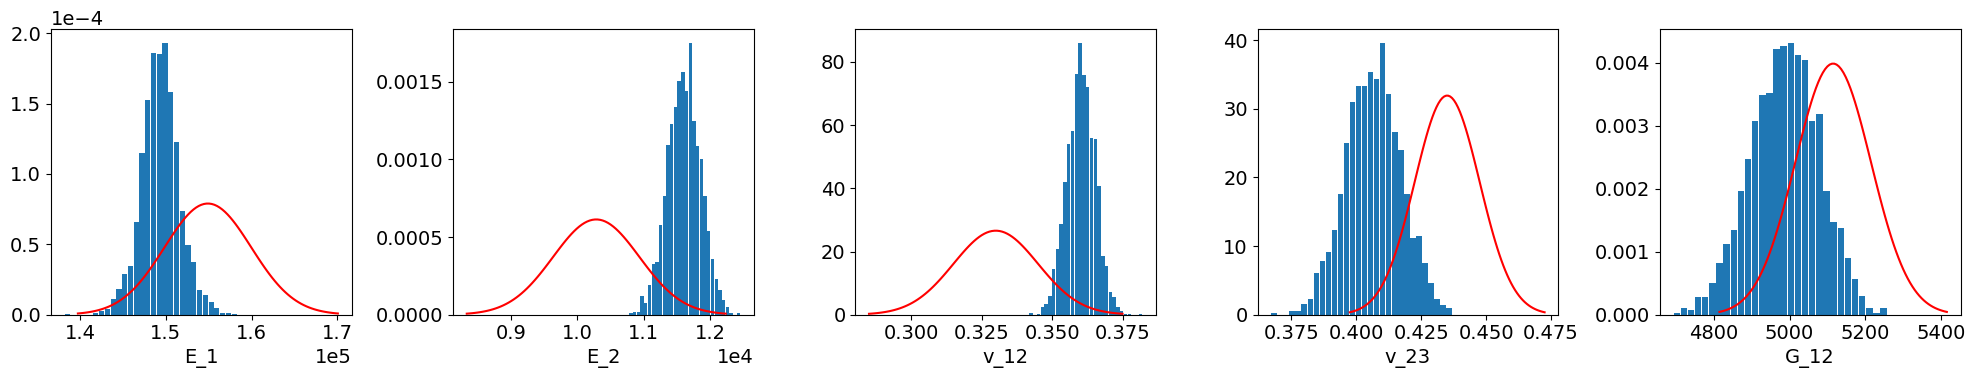

In [6]:
# plot prior-posterior distributions
import numpyro.distributions as dist
matplotlib.rcParams["axes.formatter.limits"] = [-4,4]
matplotlib.rcParams["font.size"] = 14
prior_dist = [] 
prior_dist.append(dist.Normal(154900, 5050))
prior_dist.append(dist.Normal(10285, 650))
prior_dist.append(dist.Normal(0.33, 0.015))
prior_dist.append(dist.Normal(0.435, 0.0125))
prior_dist.append(dist.Normal(5115, 100))

keys = ['E_1', 'E_2', 'v_12', 'v_23', 'G_12']
fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(20,4))
dic = {}
for i in range(len(keys)):
    x_prior = jnp.linspace(prior_dist[i].mean - 3 * prior_dist[i].variance**(0.5), prior_dist[i].mean + 3 * prior_dist[i].variance**(0.5), 100)
    ax[i].plot(x_prior, jnp.exp(prior_dist[i].log_prob(x_prior)), 'r')  
    ax[i].hist(samples[keys[i]], bins=30, rwidth=0.9, density=True)
    ax[i].set_xlabel(keys[i])
    dic[keys[i]] = samples[keys[i]]
fig.tight_layout()
